In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv("../../datasets/medical_cost.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [8]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Ridge Regression

### From Scratch

In [18]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=["charges", "sex", "smoker", "region"])
y = data["charges"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [19]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std

In [20]:
n_features = X_train_scaled.shape[1]
m = y_train.shape[0]

b = 0
w = np.zeros(n_features)
lambda_ = 0.1

lr = 0.01
epoches = 1000
losses = []
for epoch in range(epoches):
    y_pred = b + X_train_scaled.dot(w)
    diff = y_pred - y_train
    l2_penalty = lambda_ * np.sum(w ** 2)
    loss = np.mean(diff ** 2) + l2_penalty
    losses.append(loss)

    db = (2 / m) * np.sum(diff)
    l2_grad = 2 * lambda_ * w
    dw = (2 / m) * X_train_scaled.T.dot(diff) + l2_grad

    b-= lr * db
    w-= lr * dw

    if epoch % 200 == 0:
        print(f"{epoch} Iteration:")
        print(f"Ridge Loss: {loss:.2f}")
    if epoch > 1 and abs(losses[-1] - losses[-2]) < 1e-6:
        print(f"Early stopping at {epoch}. iteration")
        break 
    
    

0 Iteration:
Ridge Loss: 322451733.18
200 Iteration:
Ridge Loss: 129829985.68
400 Iteration:
Ridge Loss: 129774078.86
600 Iteration:
Ridge Loss: 129774061.73
Early stopping at 734. iteration


In [21]:
y_pred_train = b + X_train_scaled.dot(w)
y_pred_test = b + X_test_scaled.dot(w)

diff_train = y_train - y_pred_train
diff_test = y_test - y_pred_test

train_mse = np.mean(diff_train ** 2)
test_mse = np.mean(diff_test ** 2)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

df = pd.DataFrame(
    columns= ["MSE", "RMSE"],
    index=["Train", "Test"],
    data=[[train_mse, train_rmse], [test_mse, test_rmse]]
)
df

,MSE,RMSE
Train,1.285816e+08,11339.383777
Test,1.320493e+08,11491.268641


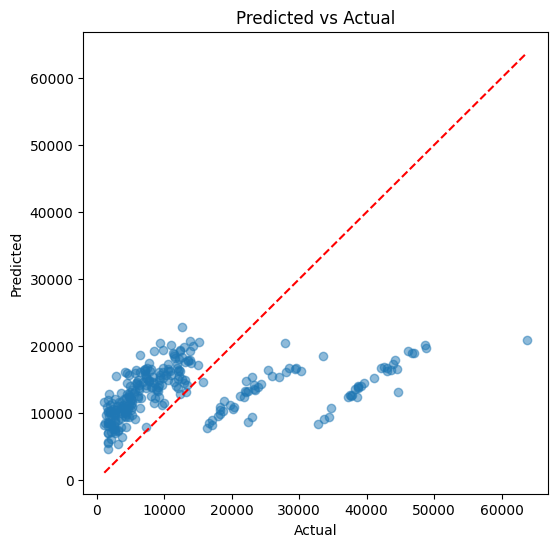

In [22]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
lims = [y_test.min(), y_test.max()]
plt.plot(lims, lims, "--r")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()

### With Sklearn

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

X = data.drop(columns=["charges"])
y = data["charges"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [42]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

num_features = ["age", "bmi", "children"]
cat_features = ["sex", "smoker", "region"]

numerical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numerical_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", Ridge())
])

param_grid = {
    "model__alpha": np.logspace(-4, 1, 20)
}
ridge_grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

ridge_grid.fit(X_train, y_train)

print(f"Best params: {ridge_grid.best_params_}")
print(f"Best score: {-ridge_grid.best_score_}")

Best params: {'model__alpha': np.float64(0.8858667904100823)}
Best score: 6146.995087418154


In [28]:
from sklearn.metrics import mean_squared_error

best_model = ridge_grid.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

df = pd.DataFrame(
    columns= ["MSE", "RMSE"],
    index=["Train", "Test"],
    data=[[mse_train, rmse_train], [mse_test, rmse_test]]
)
df

,MSE,RMSE
Train,3.727829e+07,6105.595196
Test,3.361753e+07,5798.062769


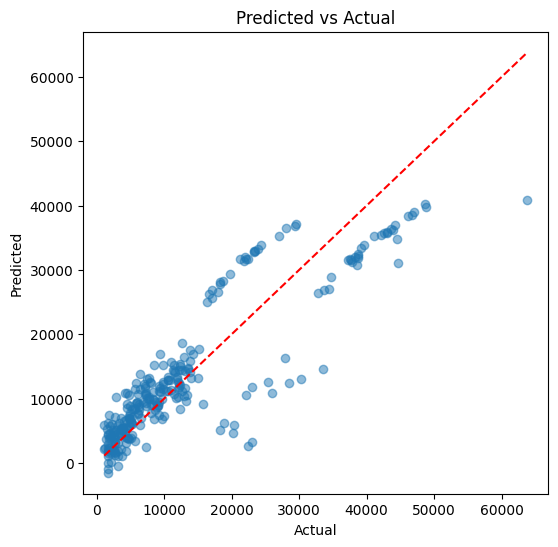

In [29]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
lims = [y_test.min(), y_test.max()]
plt.plot(lims, lims, "--r")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()

## Lasso Regression

### From Scratch

In [37]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=["charges", "sex", "smoker", "region"])
y = data["charges"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std

In [72]:
n_features = X_train_scaled.shape[1]
m = y_train.shape[0]

b = 0
w = np.zeros(n_features)
lambda_ = 0.1

lr = 0.01
epoches = 1000
losses = []

for epoch in range(epoches):
    y_predict = b + X_train_scaled.dot(w)
    diff = y_predict - y_train
    l1_penalty = lambda_ * np.sum(np.abs(w))
    loss = np.mean(diff ** 2) + l1_penalty
    losses.append(loss)

    l1_grad = lambda_ * np.sign(w)
    dw = (2/m) * X_train_scaled.T.dot(diff) + l1_grad
    db = (2/m) * np.sum(diff)

    w-= lr * dw
    b-= lr * db

    if epoch % 200 == 0:
        print(f"{epoch} Iteration:")
        print(f"Lasso Loss: {loss:.2f}")
    if epoch > 1 and abs(losses[-1] - losses[-2]) < 1e-6:
        print(f"Early stopping at {epoch}. iteration")
        break 

0 Iteration:
Lasso Loss: 322451733.18
200 Iteration:
Lasso Loss: 128532732.22
400 Iteration:
Lasso Loss: 128475604.51
600 Iteration:
Lasso Loss: 128475586.93
Early stopping at 736. iteration


In [40]:
y_pred_train = b + X_train_scaled.dot(w)
y_pred_test = b + X_test_scaled.dot(w)

diff_train = y_train - y_pred_train
diff_test = y_test - y_pred_test

train_mse = np.mean(diff_train ** 2)
test_mse = np.mean(diff_test ** 2)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

df = pd.DataFrame(
    columns= ["MSE", "RMSE"],
    index=["Train", "Test"],
    data=[[train_mse, train_rmse], [test_mse, test_rmse]]
)
df

,MSE,RMSE
Train,1.284750e+08,11334.681602
Test,1.312015e+08,11454.320369


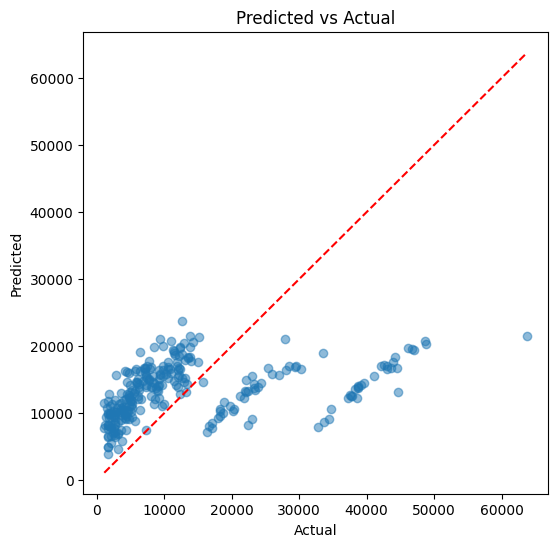

In [41]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
lims = [y_test.min(), y_test.max()]
plt.plot(lims, lims, "--r")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()

### With Sklearn

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X = data.drop(columns=["charges"])
y = data["charges"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [50]:
from sklearn.linear_model import Lasso

num_features = ["age", "bmi", "children"]
cat_features = ["sex", "smoker", "region"]

numerical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numerical_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", Lasso(max_iter=10000))
])
param_grid = {
    "model__alpha": np.logspace(-2, 1, 20)
}
lasso_grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error"
)
lasso_grid.fit(X_train, y_train)


print(f"Best params: {lasso_grid.best_params_}")
print(f"Best score: {-lasso_grid.best_score_}")

Best params: {'model__alpha': np.float64(10.0)}
Best score: 6144.110289151957


In [51]:
from sklearn.metrics import mean_squared_error

best_model = lasso_grid.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

df = pd.DataFrame(
    columns= ["MSE", "RMSE"],
    index=["Train", "Test"],
    data=[[train_mse, train_rmse], [test_mse, test_rmse]]
)
df

,MSE,RMSE
Train,1.285816e+08,11339.383777
Test,1.320493e+08,11491.268641


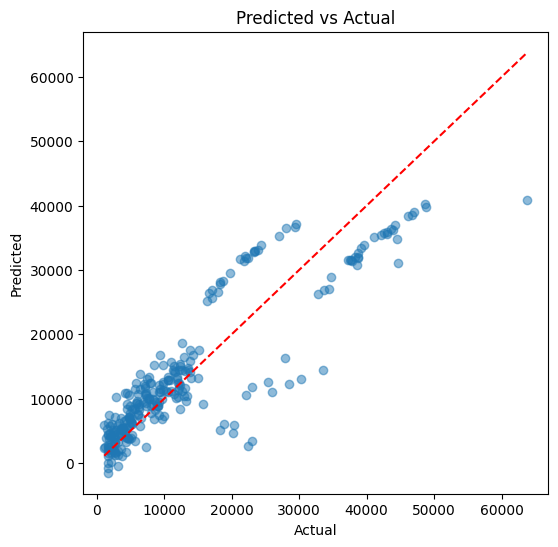

In [52]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
lims = [y_test.min(), y_test.max()]
plt.plot(lims, lims, "--r")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()

## ElasticNet Regression

### From Scratch

In [48]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=["charges", "sex", "smoker", "region"])
y = data["charges"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [49]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std

In [73]:
n_features = X_train_scaled.shape[1]
m = y_train.shape[0]

b = 0.0
w = np.zeros(n_features)

lr = 0.01
alpha = 0.5
lambda_ = 0.01
epoches = 1000
losses = []

for epoch in range(epoches):
    y_pred = b + X_train_scaled.dot(w)
    diff = y_pred - y_train

    l1_penalty = alpha * np.sum(np.abs(w))
    l2_penalty = (1 - alpha) * np.sum(w ** 2)
    loss = np.mean(diff ** 2) + lambda_ * (l1_penalty + l2_penalty)
    losses.append(loss)
    l1_grad = alpha * np.sign(w)
    l2_grad = 2 * (1 - alpha) * w

    dw = (2/m) * X_train_scaled.T.dot(diff) + lambda_ * (l1_grad + l2_grad)
    db = (2/m) * np.sum(diff)

    w-=lr * dw
    b-=lr * db

    if epoch % 200 == 0:
        print(f"{epoch} Iteration:")
        print(f"ElasticNet Loss: {loss:.2f}")
    if epoch > 1 and abs(losses[-1] - losses[-2]) < 1e-6:
        print(f"Early stopping at {epoch}. iteration")
        break  
    



0 Iteration:
ElasticNet Loss: 322451733.18
200 Iteration:
ElasticNet Loss: 128602536.61
400 Iteration:
ElasticNet Loss: 128545499.98
600 Iteration:
ElasticNet Loss: 128545482.45
Early stopping at 736. iteration


In [64]:
y_pred_train = b + X_train_scaled.dot(w)
y_pred_test = b + X_test_scaled.dot(w)

diff_train = y_pred_train - y_train
diff_test = y_pred_test - y_test

mse_train = np.mean(diff_train ** 2)
mse_test = np.mean(diff_test ** 2)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)


df = pd.DataFrame(
    columns= ["MSE", "RMSE"],
    index=["Train", "Test"],
    data=[[mse_train, rmse_train], [mse_test, rmse_test]]
)
df


,MSE,RMSE
Train,1.284753e+08,11334.695445
Test,1.312422e+08,11456.097330


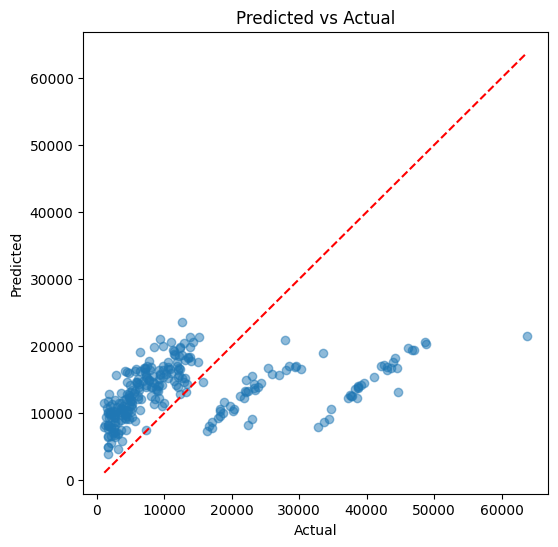

In [65]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
lims = [y_test.min(), y_test.max()]
plt.plot(lims, lims, "--r")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()

### With Sklearn

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X = data.drop(columns=["charges"])
y = data["charges"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [59]:
from sklearn.linear_model import ElasticNet

num_features = ["age", "bmi", "children"]
cat_features = ["sex", "smoker", "region"]

numerical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numerical_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", ElasticNet(max_iter=10000))
])

param_grid = {
    "model__alpha": np.logspace(-2, 1, 20),
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}

elasticnet_grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

elasticnet_grid.fit(X_train, y_train)

print(f"Best params: {elasticnet_grid.best_params_}")
print(f"Best score: {-elasticnet_grid.best_score_}")

Best params: {'model__alpha': np.float64(0.01), 'model__l1_ratio': 0.9}
Best score: 6146.992826033653


In [60]:
best_model = elasticnet_grid.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)


mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

df = pd.DataFrame(
    columns= ["MSE", "RMSE"],
    index=["Train", "Test"],
    data=[[train_mse, train_rmse], [test_mse, test_rmse]]
)
df

,MSE,RMSE
Train,1.285816e+08,11339.383777
Test,1.320493e+08,11491.268641


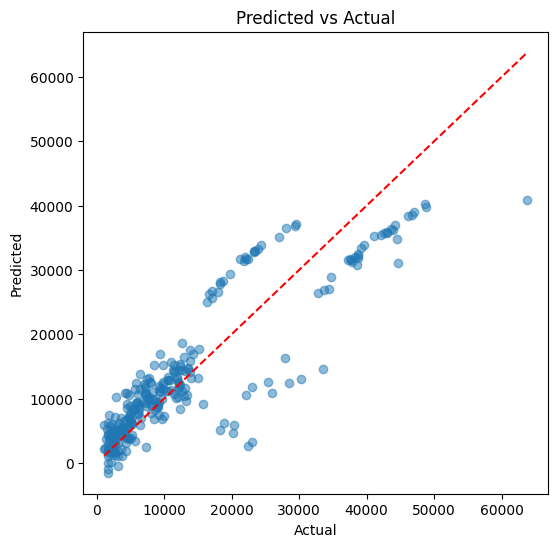

In [61]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
lims = [y_test.min(), y_test.max()]
plt.plot(lims, lims, "--r")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()